In [28]:
%cd /home/teresakim/fungiclef-2024/

/home/teresakim/fungiclef-2024


In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import pyspark.sql.functions as f
import pyspark.ml as ml
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, FloatType, IntegerType
import fungiclef.embedding.transforms as trans
from fungiclef.utils import get_spark

In [31]:
spark = get_spark(**{
    "spark.sql.parquet.enableVectorizedReader": False, 
})
display(spark)

24/04/28 22:24:00 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/04/28 22:24:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [42]:
gcs_parquet_path = "gs://dsgt-clef-fungiclef-2024/"

# define the embedding path here
#------------resnet embedding (original)
# input_folder = f"data/parquet/DF20_300px_resnet18" # 295,938 total
# embedding_name = "ResNet"

# ------------resnet embedding (300px full set)
# input_folder = f"data/parquet/DF20_300px_and_DF21_300px_corrected_FULL_SET_embedding/resnet" # 356,770
# embedding_name = "ResNet_300px"
input_folder = f"production/resnet/" # 354,866
embedding_name = "ResNet"

# ------------dino embedding (300px full set 8x8)
# input_folder = "data/parquet/DF20_300px_and_DF21_300px_corrected_FULL_SET_embedding/dino_dct/data" # 356,738
# embedding_name = "DINO 8x8"

# ------------dino embedding (300px full set 16x16)
# input_folder = "data/parquet/DF20_300px_and_DF21_300px_corrected_FULL_SET_embedding/dino_dct_16/data" # 356,738
# embedding_name = "DINO 16x16"

# ------------dino embedding (300px full set CLT)
# input_folder = "production/dino_cls/" # 350,974
# embedding_name = "DINO CLS"


# ------------clip embedding # TBD
# embedding_name = "CLIP"

embedding_df = spark.read.parquet(gcs_parquet_path+input_folder)
embedding_df.printSchema()
embedding_df.count()

root
 |-- image_path: string (nullable = true)
 |-- observationID: long (nullable = true)
 |-- month: double (nullable = true)
 |-- day: double (nullable = true)
 |-- locality: long (nullable = true)
 |-- level0Gid: long (nullable = true)
 |-- level1Gid: long (nullable = true)
 |-- level2Gid: long (nullable = true)
 |-- Substrate: long (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- CoorUncert: double (nullable = true)
 |-- Habitat: long (nullable = true)
 |-- MetaSubstrate: long (nullable = true)
 |-- kingdom: long (nullable = true)
 |-- phylum: long (nullable = true)
 |-- class: long (nullable = true)
 |-- order: long (nullable = true)
 |-- family: long (nullable = true)
 |-- genus: long (nullable = true)
 |-- species: long (nullable = true)
 |-- poisonous: long (nullable = true)
 |-- class_id: long (nullable = true)
 |-- dataset: string (nullable = true)
 |-- embeddings: array (nullable = true)
 |    |-- element: float (contain

354866

In [8]:
# for option 2
gcs_parquet_path = "gs://dsgt-clef-fungiclef-2024/data/parquet/"

# define the embedding path here
# ------------dino embedding (300px combined)
input_folder = "DF20_300px_and_DF21_300px_train_embedding/dino/data/sample_id=0"
embedding_name = "DINO"

# ------------clip embedding # TBD
# embedding_name = "CLIP"

embedding_df = spark.read.parquet(gcs_parquet_path+input_folder)
embedding_df.printSchema()
embedding_df.count()

root
 |-- ImageUniqueID: string (nullable = true)
 |-- species: string (nullable = true)
 |-- dino_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)



22382

### option 1

In [43]:
# option 1: sampling by top 5 species

# count the occurrences of each species and order by the count descending
species_counts = embedding_df.groupBy("species").count().orderBy(col("count").desc())

# get the top 5 species
top_species = species_counts.limit(5).select("species").rdd.flatMap(lambda x: x).collect()

In [44]:
# define a sample fraction, example: 10%
sample_fraction = 1.0

# filter the original df to include only records from the top 5 species and sample from them
sampled_df = embedding_df.filter(col("species").isin(top_species)).sampleBy("species", fractions={x: sample_fraction for x in top_species})

sampled_df.show()

+--------------------+-------------+-----+----+--------+---------+---------+---------+---------+------------------+---------+----------+-------+-------------+-------+------+-----+-----+------+-----+-------+---------+--------+-------+--------------------+-----------------+
|          image_path|observationID|month| day|locality|level0Gid|level1Gid|level2Gid|Substrate|          Latitude|Longitude|CoorUncert|Habitat|MetaSubstrate|kingdom|phylum|class|order|family|genus|species|poisonous|class_id|dataset|          embeddings|__index_level_0__|
+--------------------+-------------+-----+----+--------+---------+---------+---------+---------+------------------+---------+----------+-------+-------------+-------+------+-----+-----+------+-----+-------+---------+--------+-------+--------------------+-----------------+
|2465026805-200675...|   2465026805| 12.0| 8.0|    8816|        9|       31|      133|        6|         54.765611|12.037556|      15.0|      2|            8|      1|     2|    0|  

In [45]:
import pacmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
from sklearn.preprocessing import StandardScaler

# Convert to Pandas DF
pandas_df = sampled_df.select(["embeddings", "species"]).toPandas() # resnet
# pandas_df = sampled_df.select(["dct_embedding", "species"]).toPandas() # dino
# pandas_df = sampled_df.select(["embedding", "species"]).toPandas() # dino cls

# Extract features and labels
emb_df = np.stack(pandas_df["embeddings"].values) # resnet
# emb_df = np.stack(pandas_df["dct_embedding"].values) # dino
# emb_df = np.stack(pandas_df["embedding"].values) # dino cls
scaled_emb = StandardScaler().fit_transform(emb_df)
labels = pandas_df["species"].tolist()

# PACMAP reduction
reducer = pacmap.PaCMAP(n_components=2, n_neighbors=15, MN_ratio=0.5, FP_ratio=2.0) 
embedding = reducer.fit_transform(scaled_emb, init="pca") 

In [47]:
def plot_cluster(pandas_df, embeddings, algorithm_name):
    # Plot the data
    fig, ax = plt.subplots(figsize=(8.8, 4.8), dpi=200)
    fig.suptitle(
        f"{algorithm_name} projection of top 5 fungi species ({embedding_name})",
        fontsize=14,
        weight="bold",
    )

    # Create a scatter plot, color-coded by new species_idx
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    top_species_idx = pandas_df["species"].value_counts().nlargest(5).index
    species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

    # Map species IDs to colors for plotting
    color_list = pandas_df["species"].map(species_to_color).tolist()

    for species, color in species_to_color.items():
        # Select embeddings for the current species
        idx = pandas_df["species"] == species
        ax.scatter(
            embeddings[idx, 0],
            embeddings[idx, 1],
            c=color,
            # cmap="tab10",
            label=species,
            s=4,
            alpha=0.7,
            linewidth=0.5,
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    ax.legend(loc="best", title="Species Name", fontsize="small")
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    fig.savefig(f"notebooks/evaluation/visuals/{embedding_name}_{algorithm_name}.png")
    plt.show()

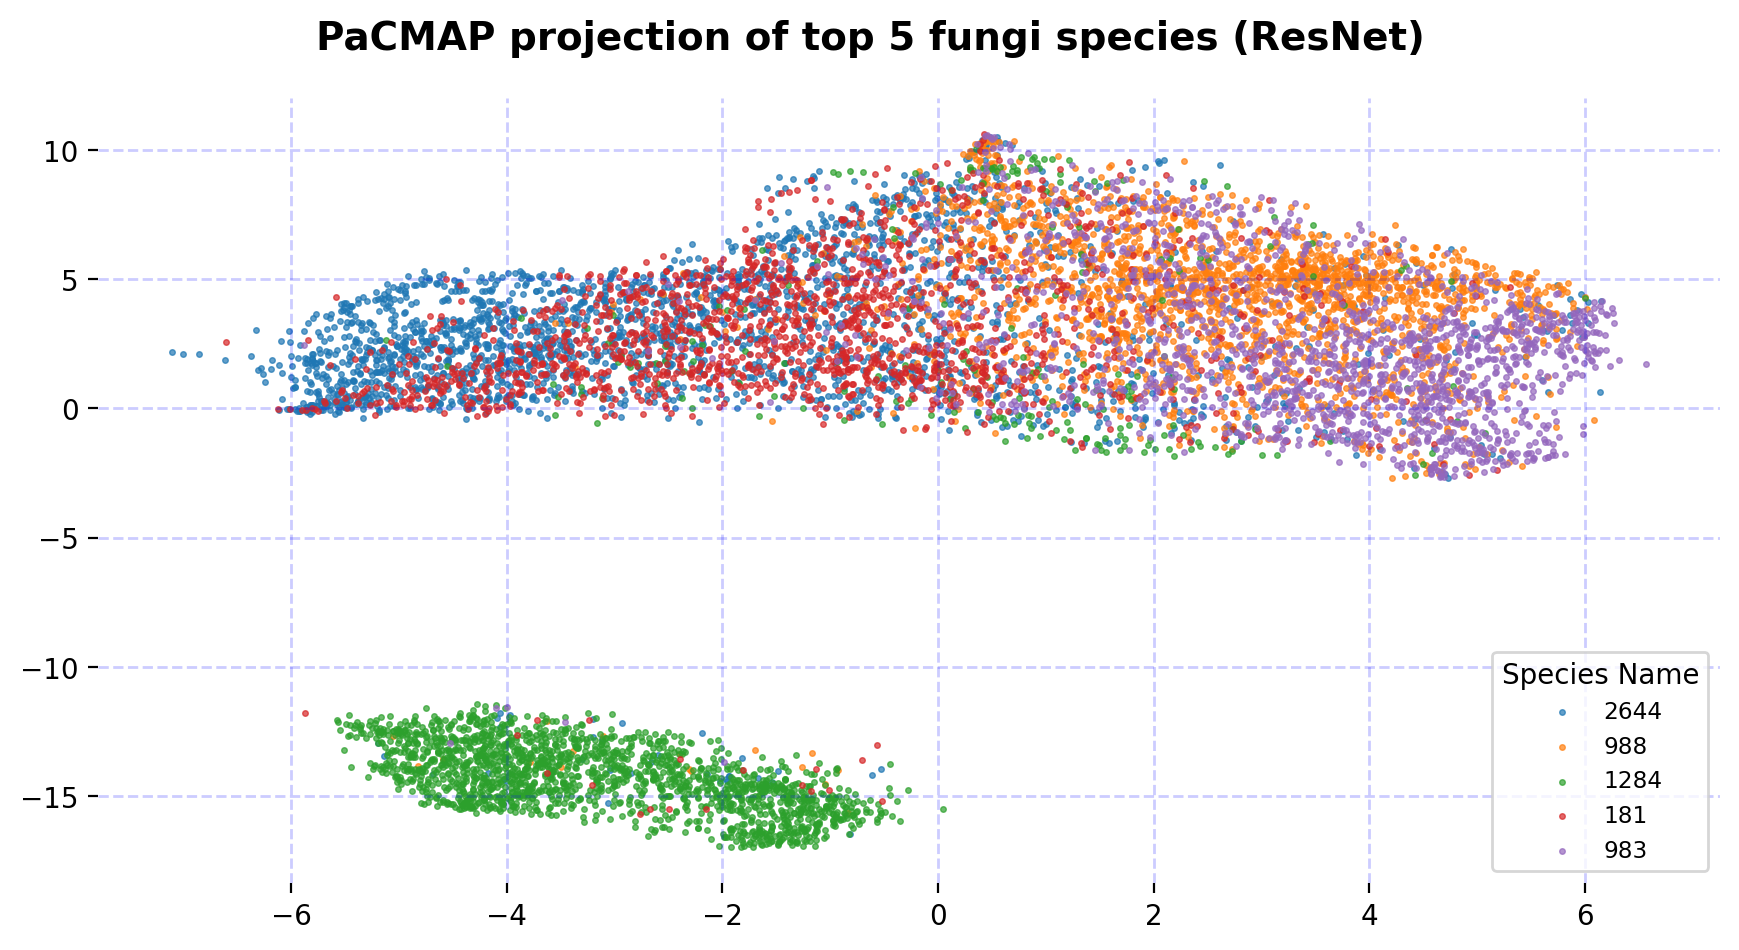

In [48]:
plot_cluster(pandas_df, embedding, algorithm_name="PaCMAP")


In [49]:
spark.stop()

### option 2